In [34]:
from langgraph.checkpoint.memory import MemorySaver

memory = MemorySaver()

In [35]:
from langchain_community.utilities import ArxivAPIWrapper, WikipediaAPIWrapper
from langchain_community.tools import ArxivQueryRun, WikipediaQueryRun

arxiv_wrapper = ArxivAPIWrapper(top_k_results=1,doc_content_chars_max=300)
arxiv_tool = ArxivQueryRun(api_wrapper=arxiv_wrapper)

api_wrapper = WikipediaAPIWrapper(top_k_results=1,doc_content_CHARS_MAX=300)
wiki_tool=WikipediaQueryRun(api_wrapper=api_wrapper)

In [36]:
tools=[arxiv_tool,wiki_tool,]

In [37]:
from typing_extensions import TypedDict
from typing import Annotated
from langgraph.graph.message import add_messages

class State(TypedDict):
    messages:Annotated[list,add_messages]

In [38]:
from langgraph.graph import StateGraph, START, END
graph_builder = StateGraph(State)

In [39]:
tools=[wiki_tool,arxiv_tool]

In [40]:
import os
from langchain_groq import ChatGroq
groq_api_key=os.environ.get("groq_api_key")

llm =ChatGroq(groq_api_key=groq_api_key)

In [41]:
llm.invoke("Hey").content

"Hello! How can I help you today? If you have any questions about programming, web development, or technology in general, feel free to ask. I'll do my best to provide a clear and helpful answer. 😊"

In [42]:
llm_with_tools=llm.bind_tools(tools)

In [43]:
def chatbot(state:State):
    return {"messages":[llm_with_tools.invoke(state["messages"])]}

from langgraph.prebuilt import ToolNode, tools_condition

graph_builder.add_node("chatbot",chatbot)
tool_node=ToolNode(tools=tools)

In [44]:
graph_builder.add_node("tools",tool_node)

graph_builder.add_conditional_edges(
    "chatbot",
    tools_condition,
)

In [45]:
graph_builder.add_edge("tools","chatbot")
graph_builder.add_edge(START,"chatbot")
graph_builder.add_edge("chatbot",END)

In [48]:
graph = graph_builder.compile(
    checkpointer=memory,
    # This is new!
    interrupt_before=["tools"],
    # Note: can also interrupt __after__ tools, if desired.
    # interrupt_after=["tools"]
)

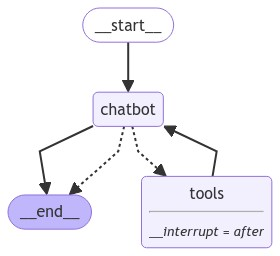

In [49]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [50]:
user_input = "I'm learning LangGraph. Could you do some research on it for me?"
config = {"configurable": {"thread_id": "1"}}
# The config is the **second positional argument** to stream() or invoke()!
events = graph.stream(
    {"messages": [("user", user_input)]}, config, stream_mode="values"
)
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================ Human Message =================================

I'm learning LangGraph. Could you do some research on it for me?
================================== Ai Message ==================================
Tool Calls:
  wikipedia (call_gcqy)
 Call ID: call_gcqy
  Args:
    query: LangGraph
================================= Tool Message =================================
Name: wikipedia

Page: LangChain
Summary: LangChain is a framework designed to simplify the creation of applications using large language models (LLMs). As a language model integration framework, LangChain's use-cases largely overlap with those of language models in general, including document analysis and summarization, chatbots, and code analysis.




In [54]:
while True:
  user_input=input()
  if user_input.lower() in ["quit","q"]:
    print("Khatam Tata Bye-bye")
    break
  if user_input:
    # The config is the **second positional argument** to stream() or invoke()!
    events = graph.stream(
        {"messages": [("user", user_input)]}, config, stream_mode="values"
    )
    for event in events:
        event["messages"][-1].pretty_print()

================================ Human Message =================================

Hello
================================== Ai Message ==================================

Hello! How can I help you today? If you have any questions about LangChain or anything else, feel free to ask!
================================ Human Message =================================

tell me about sharukh 
================================== Ai Message ==================================

Shah Rukh Khan, also known as SRK, is a renowned Indian actor, producer, and television personality. He was born on November 2, 1965, in New Delhi, India. Shah Rukh Khan is often referred to as the "King of Bollywood" or "Baadshah of Bollywood" due to his immense popularity and significant contributions to the Indian film industry.

Throughout his career, Shah Rukh Khan has appeared in numerous successful films across various genres such as romance, drama, action, and comedy. Some of his most notable movies include "Dilwale Du

KeyboardInterrupt: Interrupted by user

In [51]:
snapshot = graph.get_state(config)
snapshot.next

('chatbot',)

In [52]:
snapshot.values["messages"][-1]

ToolMessage(content="Page: LangChain\nSummary: LangChain is a framework designed to simplify the creation of applications using large language models (LLMs). As a language model integration framework, LangChain's use-cases largely overlap with those of language models in general, including document analysis and summarization, chatbots, and code analysis.\n\n", name='wikipedia', id='0aa57c24-0d8e-4826-9fbf-8f9fbf4bc9a1', tool_call_id='call_gcqy')

In [53]:
existing_message = snapshot.values["messages"][-1]
existing_message.tool_calls

AttributeError: 'ToolMessage' object has no attribute 'tool_calls'

In [ ]:
# `None` will append nothing new to the current state, letting it resume as if it had never been interrupted
events = graph.stream(None, config, stream_mode="values")
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================= Tool Message =================================
Name: wikipedia

Page: LangChain
Summary: LangChain is a framework designed to simplify the creation of applications using large language models (LLMs). As a language model integration framework, LangChain's use-cases largely overlap with those of language models in general, including document analysis and summarization, chatbots, and code analysis.


================================== Ai Message ==================================

LangChain is a framework designed to simplify the creation of applications using large language models (LLMs). It is useful for various applications such as document analysis and summarization, chatbots, and code analysis.

Based on the information from the tool, it seems that LangGraph is related to LangChain, but I couldn't find specific information about LangGraph. It might be helpful to look up LangGraph on Wikipedia to see if there is a separate page for it. If not, it coul